<a href="https://colab.research.google.com/github/Simurgh818/BMED8803_Lab5/blob/main/lab_5_spike_sorting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Spike Sorting

In this lab, you'll implement a spike sorting algorithm on a synthetic dataset.  

In [1]:
# Import PyTorch modules
import torch
import torch.nn.functional as F

# Plotting stuff
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Some helper utilities
from tqdm.auto import trange
from scipy.signal import find_peaks
from scipy.optimize import linear_sum_assignment

# !pip install neo elephant --quiet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
using_colab = True

In [7]:
if using_colab:
    import sys
    from google.colab import drive
    drive.mount('/content/gdrive/')
    sys.path.append('/content/drive/MyDrive/BMED_8803_tat_Models_for_Neural_Data/lab5/')
    test_points = torch.load("/content/gdrive/MyDrive/BMED_8803_tat_Models_for_Neural_Data/lab5/test_points.pt", map_location=device)
else:
    test_points = torch.load("./test_points.pt", map_location=device)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


<ipython-input-7-de0676d6d650>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_points = torch.load("/content/gdrive/MyDrive/BMED_8803_tat_Models_for_Neural_Data/lab5/t

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!pip install neo elephant --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 655.1/655.1 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 7.5 MB/s eta 0:00:00


In [11]:

from utils import generate_syn_sorting, generate_templates, plot_model, plot_templates

## Spike Sorting by Deconvolution

In this part of the lab you'll use those cross-correlation and convolution operations to implement the spike sorting algorithm. We'll apply the algorithm to a synthetic dataset.

Simulating data. This could take a few seconds!


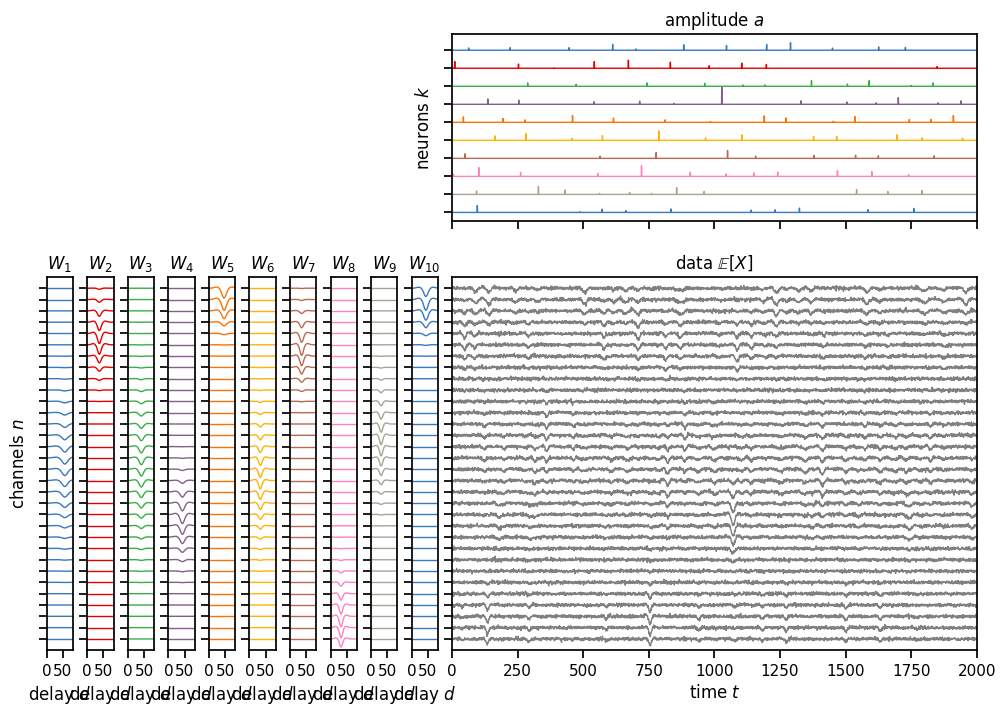

In [12]:
# Create a larger dataset with a multiple channels and neurons.
T = 100000 # number of time samples
N = 32      # number of channels
D = 81      # duration of a spike (in samples)
K = 10      # multiple neurons

# Generate random templates, amplitudes, and noisy data.
# `templates` are NxCxD and `amplitudes` are NxT
torch.manual_seed(0)
print("Simulating data. This could take a few seconds!")
true_templates, true_amplitudes, data = generate_syn_sorting(T, N, D, K)
plot_model(true_templates, true_amplitudes[:, :2000], data[:,:2000], lw=1, figsize=(12, 8))

In [14]:
# Generate another set of random templates and amplitudes to seed the model
torch.manual_seed(1)
templates = generate_templates(N, D, K)
amplitudes = torch.zeros((K, T))
noise_std = 1.0

# Copy the tensors to the GPU (if available)
templates = templates.to(device)
amplitudes = amplitudes.to(device)
data = data.to(device)

---

For the following sections, you'll use the `conv1d` function in the `torch.nn.functional` package. We've already imported that package with the shorthand name `F` so that you can call the function with `F.conv1d(...)`. Take a look at its documentation [here](https://pytorch.org/docs/stable/nn.functional.html?highlight=conv1d#torch.nn.functional.conv1d), as well as the corresponding documentation for the `torch.nn.Conv1d` object, which implements a convolutional layer for a neural network.

**Remember that `conv1d` can perform a cross-correlation with a flip weight!**

Let $\mathbf{A} \in \mathbb{R}^{B \times K \times T}$ denote the signal/input and $\mathbf{W} \in \mathbb{R}^{N \times K \times D}$ denote the filter/weights (note that the axes are permuted relative to our mathematical notes), and let $\mathbf{X} \in \mathbb{R}^{B \times N \times T - D + 1}$ denote the output. Then the cross-correlation is,

$$
\begin{align*}
x_{b,n,t} = \sum_{k = 1}^{K} \sum_{d=1}^D a_{b,k,t+d-1} w_{n,k,d}.
\end{align*}
$$

for $b=1,\ldots,B$, $n=1,\ldots,N$, and $t=1,\ldots,T-D+1$.

By default the output only contains the "valid" portion of the convolution; i.e. the $T-D+1$ samples where the inputs and weights completely overlap. If you want the "full" output, you have to call `F.conv1d(input, weights, padding=D-1)`. This pads the input with $D-1$ zeros at the beginning and end so that the resulting output is length $T + D - 1$. Depending your application, you may want the first $T$ or the last $T$ entries in this array.

**Note:** Use `conv1d` to implement a cross-correlation. Remember that you can do it by fliping the weights along the last axis $D$.

---

### Compute the Log Likelihood

One of the most awesome features of PyTorch is its `torch.distributions` package. See the docs [here](https://pytorch.org/docs/stable/distributions.html). It contains objects for many of our favorite distributions, and has convenient functions for computing log probabilities (with `d.log_prob()` where `d` is a `Distribution` object), sampling (`d.sample()`), computing the entropy (`d.entropy()`), etc. These functions broadcast as you'd expect (unlike `scipy.stats`!), and they're designed to work with automatic differentiation.  More on that another day...

For now, you'll use `MultivariateNormal` to compute the log likelihood of the data given the template and amplitudes, $\log p(\mathbf{X} \mid \mathbf{A}, \mathbf{W})$.  To do that, you'll convolve the amplitudes and templates to get the mean value of $\mathbf{X}$, which means that amplitudes should be modified to the input $\mathbf{A}$ and templates should be modified to the weight $\mathbf{W}$, then you'll use the `log_prob` function to evaluate the likelihood of the data.

In [17]:
def log_likelihood(templates, amplitudes, data, noise_std):
    """Evaluate the log likelihood"""
    K, N, D = templates.shape
    _, T = data.shape

    # Compute the model prediction by convolving the amplitude and templates
    # new_templates = torch.filp(torch.permute(..., ...), ...)
    # pred = F.conv1d(input=..., weight=...,padding=...)[:,:,0:T]
    # pred = torch.squeeze(pred)
    # dis = torch.distributions.multivariate_normal.MultivariateNormal(...)

    # YOUR CODE HERE
    new_templates = torch.flip(torch.permute(templates, [1, 0, 2]), [2])
    pred = torch.squeeze(F.conv1d(input=amplitudes[None,:,:], weight=new_templates, padding=D-1)[:,:,0:T])
    dis = torch.distributions.multivariate_normal.MultivariateNormal(pred.T, torch.eye(pred.shape[0]) * noise_std**2)

    # raise NotImplementedError()

    # Evaluate the log probability using dist.Normal
    ll = torch.sum(dis.log_prob(data.T))

    # Return the log probability normalized by the data size
    return ll / (N * T)

In [18]:
# test your answer
ll = log_likelihood(templates, amplitudes, data, noise_std)
assert ll.isclose(test_points["q1"], atol=1e-3)

### Compute the residual

Compute the residual for a specified neuron by subtracting the convolved amplitudes and templates for all the other neurons. The amplitudes for all the other neurons should be modified to the input $\mathbf{A}$ and the templates for all the other neurons should be modified to the weight $\mathbf{W}$

In [19]:
def compute_residual(neuron, templates, amplitudes, data):
    K, C, D = templates.shape
    T = data.shape[1]  # Get the value of T from the data shape

    # Compute the predicted value of the data by
    # convolving the amplitudes and the templates for all
    # neurons except the specified one.

    indexes_without_neuron = torch.cat([torch.arange(neuron), torch.arange(neuron+1, K)])
    amplitudes_without_neuron = amplitudes[indexes_without_neuron]

    # new_templates = torch.filp(torch.permute(..., ...), ...)
    # pred = F.conv1d(input=..., weight=...,padding=...)[:,:,0:T]
    # pred = torch.squeeze(pred)
    new_templates = torch.flip(torch.permute(templates[indexes_without_neuron], [1, 0, 2]), [2])
    pred = F.conv1d(input=amplitudes_without_neuron[None,:,:], weight=new_templates, padding=D-1)[:,:,0:T]
    pred = torch.squeeze(pred)

    # YOUR CODE HERE
    # raise NotImplementedError()

    # Return the data minus the predicted value given other neurons
    return data - pred

In [20]:
# test your answer
residual = compute_residual(0, templates, amplitudes, data)
assert residual[16, [0, 1234, -1]].allclose(test_points["q2"], atol=1e-4)

### Compute the score

Let the "score" for neuron $k$ be the cross-correlation of the residual and its template. Compute it using `conv1d`. Residual should be modified to the input $\mathbf{A}$ and the templates should be modified to the weight $\mathbf{W}$

In [21]:
def compute_score(neuron, templates, amplitudes, data):
    K, N, D = templates.shape
    T = data.shape[1]

    # First get the residual
    residual = compute_residual(neuron, templates, amplitudes, data)

    # score = F.conv1d(input=..., weight=...,padding=...)[:, :, D-1:]
    score = F.conv1d(input=residual[None,:,:], weight=templates[neuron][None,:,:], padding=D-1)[:, :, D-1:]
    score = torch.squeeze(score)

    # YOUR CODE HERE
    # raise NotImplementedError()

    return torch.squeeze(score)

In [22]:
# test your answer
score = compute_score(0, templates, amplitudes, data)
assert score[[0, 1234, -1]].allclose(test_points["q3"], atol=1e-4)

### Update the amplitudes using `find_peaks`

Our next step is to update the amplitudes given the scores. We'll use a simple heuristic as described in the course: use `scipy.signal.find_peaks` to find peaks in the score that are separated by a distance of at least $D$ samples and at least a height of $\sigma^2 \lambda$, where $\sigma$ is the standard deviation of the noise and $\lambda$ is the amplitude rate hyperparameter.

Note that this solution does not guarantee that the resulting nonzero amplitudes will be separated by at least $D$ time steps! In practice, we can enforce this constraint via the following heuristic: after solving for the optimal amplitudes, use the `scipy.signal.find_peaks` function to keep only a subset of nonzero amplitudes that are separated by a distance of $D$

In [23]:
def _update_amplitude(neuron, templates, amplitudes, data,
                      noise_std=1.0, amp_rate=5.0):
    K, N, D = templates.shape
    T = data.shape[1]

    # Compute the score and convert it to a numpy array.
    score = compute_score(neuron, templates, amplitudes, data).to("cpu")

    # Initialize the new amplitudes a_k for this neuron
    new_amplitude = torch.zeros(T, device=device)

    # peaks, props = scipy.signal.find_peaks(..., distance=..., height=...)
    peaks, props = find_peaks(score, distance=D, height=noise_std**2 * amp_rate)

    # YOUR CODE HERE
    # raise NotImplementedError()

    # Convert the peak heights to a tensor
    heights = torch.tensor(props['peak_heights'],
                           dtype=torch.float32, device=device)

    # Compute the new amplitude for this neuron.
    new_amplitude[peaks] = heights

    ###

    return new_amplitude

In [24]:
# test your anseer
amplitudes[0] = _update_amplitude(0, templates, amplitudes, data)
assert torch.allclose(amplitudes[0][[136, 253, 898, -1]].to("cpu"),
                      test_points["q4"])

### Update the templates
Our last step is to update the template for a given neuron by projecting the _target_ $\overline{\mathbf{R}} \in \mathbb{R}^{N \times D}$. The target is the sum of scaled residuals at the times of spikes in the amplitudes:

$$
\begin{align}
    \overline{\mathbf{R}} = \sum_t a_{k,t} \mathbf{R}_{:,t:t+D}.
\end{align}
$$

where $\mathbf{R} \in \mathbb{R}^{N \times T}$ denotes the residual for neuron $n$.

To get the template, project $\overline{\mathbf{R}}$ onto $\mathcal{S}_K^{(N,D)}$, the set of rank-$K$, unit-norm, $N \times D$ matrices, using the SVD.

In [37]:
def _update_template(neuron, templates, amplitudes, data, template_rank=1):
    K, N, D = templates.shape
    T = data.shape[1]

    # Initialize the new template
    new_template = torch.zeros((N, D), device=device)

    # Check if the factor is used. If not, generate a random new one.
    if amplitudes[neuron].sum() < 1:
        target = generate_templates(N, D, 1)[0]

    else:
        # Get the residual using the function you wrote above
        residual = compute_residual(neuron, templates, amplitudes, data)

        # Compute the \bar{R} based on the above formula: \bar{R} = \sum_{t}aR
        # bar_R = ...

        # YOUR CODE HERE
        bar_R = torch.zeros((N, D), device=device)
        for t in range(T - D +1):
            bar_R += amplitudes[neuron, t] * residual[:, t:t+D]

        # raise NotImplementedError()


    ###
    # Project the target onto the set of normalized rank-K templates using
    # `torch.linalg.svd` and `torch.linalg.norm`.

    # U, S, VT = torch.linalg.svd(...)
    # S = torch.diag(S)
    # S_K = S[...]
    # S_K_norm = ...
    # new_template = U[...] @ S_K_norm @ VT[...]

    # YOUR CODE HERE
    U, S, VT = torch.linalg.svd(bar_R)

    # Reshape S to be a diagonal matrix
    S = torch.diag(S)

    S_K = S[:template_rank, :template_rank] # Select top template_rank singular values

    # Normalize singular values
    S_K_norm = S_K / torch.linalg.norm(S_K)

    S_K_norm = S_K / torch.norm(S_K, dim=1, keepdim=True)
    new_template = U[:, :template_rank] @ S_K_norm @ VT[:template_rank, :]

    # raise NotImplementedError()

    return new_template

In [38]:
# test your answer
# Set amplitudes using previous cell output
# so the template update code is executed
templates[0] = _update_template(0, templates, amplitudes, data)
assert torch.linalg.norm(templates[0], 'fro').isclose(
    torch.tensor(1.0), atol=1e-4)
assert templates[0][16, 44].isclose(test_points["q5"], atol=1e-4)

### Put it all together

That's it! We've written a little function to perform coordinate ascent using your `_update_*` functions. It tracks the log likelihood at each iteration. It also uses some nice progress bars so you can see how fast (or slow?) your code runs.

In [39]:
def map_estimate(templates,
                 amplitudes,
                 data,
                 num_iters=20,
                 template_rank=1,
                 noise_std=1.0,
                 amp_rate=5.0,
                 tol=1e-4):
    """Fit the templates and amplitudes by maximum a posteriori (MAP) estimation
    """
    K, N, D = templates.shape

    # Make fancy reusable progress bars
    outer_pbar = trange(num_iters)
    inner_pbar = trange(K)
    inner_pbar.set_description("updating neurons")

    # Track log likelihoods over iterations
    lls = [log_likelihood(templates, amplitudes, data, noise_std=noise_std)]
    for itr in outer_pbar:
        inner_pbar.reset()
        for k in range(K):
            # Update the amplitude
            amplitudes[k] = _update_amplitude(
                k, templates, amplitudes, data,
                noise_std=noise_std, amp_rate=amp_rate)
            # Update the template
            templates[k] = _update_template(
                k, templates, amplitudes, data, template_rank=template_rank)
            inner_pbar.update()

        # Compute the log likelihood
        lls.append(log_likelihood(templates, amplitudes, data,
                                  noise_std=noise_std))

        # Check for convergence
        if abs(lls[-1] - lls[-2]) < tol:
            print("Convergence detected!")
            break

    return torch.stack(lls)

### Fit the synthetic data and plot the log likelihoods

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Convergence detected!


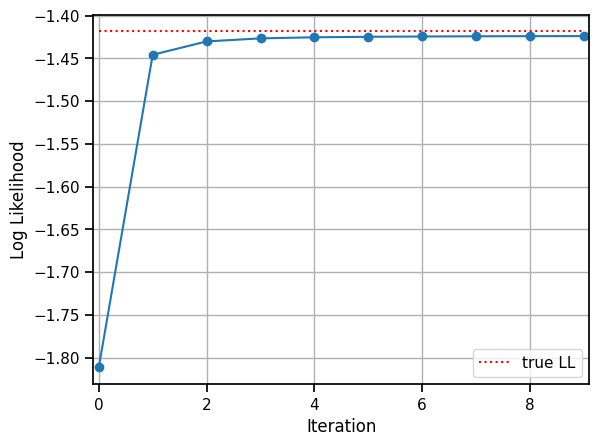

In [40]:
# Make random templates and set amplitude to zero
torch.manual_seed(0)
templates = generate_templates(N, D, K)
amplitudes = torch.zeros((K, T), device=device)
noise_std = 1.0     # \sigma
amp_rate = 5.0      # \lambda

# Copy to the device
true_templates = true_templates.to(device)
true_amplitudes = true_amplitudes.to(device)
templates = templates.to(device)
amplitudes = amplitudes.to(device)
data = data.to(device)

# Fit the model.
lls = map_estimate(templates, amplitudes, data,
                   noise_std=noise_std,
                   amp_rate=amp_rate)

# For comparison, compute the log likelihood with the true templates
# and amplitudes.
true_ll = log_likelihood(true_templates, true_amplitudes, data, noise_std)

# Plot the log likelihoods
lls = lls.to("cpu")
true_ll = true_ll.to("cpu")

plt.plot(lls, '-o')
plt.hlines(true_ll, 0, len(lls) - 1,
           colors='r', linestyles=':', label="true LL")
plt.xlabel("Iteration")
plt.xlim(-.1, len(lls) - .9)
plt.ylabel("Log Likelihood")
plt.grid(True)
plt.legend(loc="lower right")

### Find a permutation of the inferred neurons that best matches the true neurons

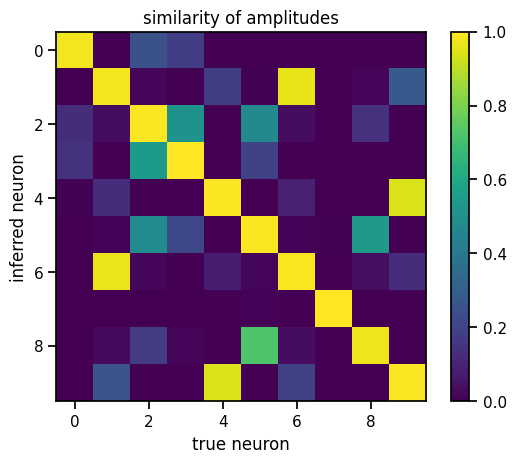

In [41]:
# Compute the similarity (inner product) of the true and inferred templates
similarity = torch.zeros((K, K))
for i in range(K):
    for j in range(K):
        similarity[i, j] = torch.sum(true_templates[i] * templates[j])

# Show the similarity matrix
_, perm = linear_sum_assignment(similarity, maximize=True)
plt.imshow(similarity[:, perm], vmin=0, vmax=1)
plt.xlabel("true neuron")
plt.ylabel("inferred neuron")
plt.title("similarity of amplitudes")
plt.colorbar()

### Plot the true and inferred templates

They should line up pretty well.

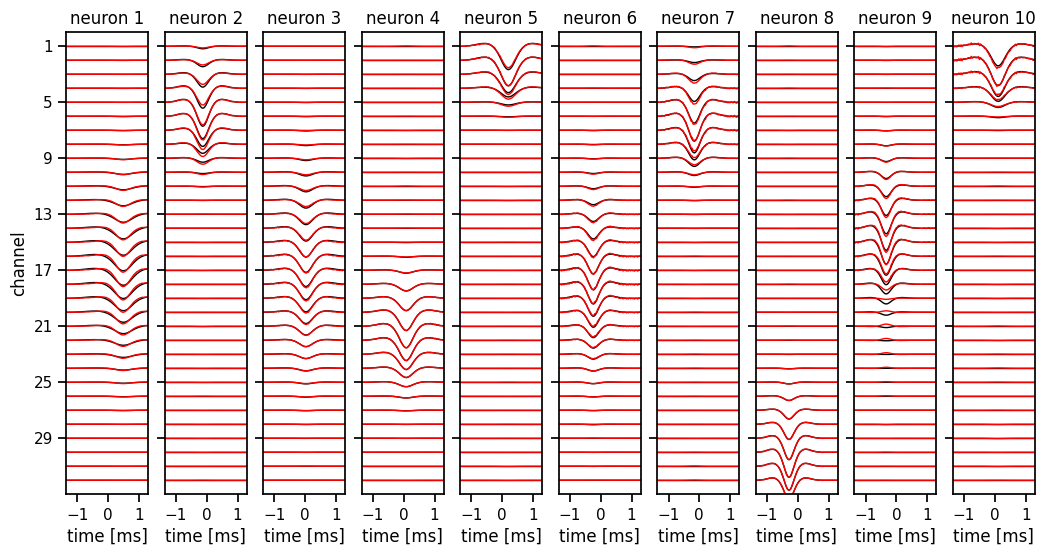

In [42]:
# Plot the true and inferred templates, permuted to best match
fig, axs = plot_templates(true_templates.to("cpu"), torch.arange(K), n_cols=K)
_ = plot_templates(templates[perm].to("cpu"),
                   torch.arange(K),
                   n_cols=K,
                   colors=('r',),
                   fig=fig,
                   axs=axs)